# Exploratory Data Analysis (EDA) on Grocery Store Database

This notebook performs an **Exploratory Data Analysis (EDA)** directly on a PostgreSQL database that was built and containerized with Docker.  
The database simulates a **grocery/retail analytics scenario**, including customers, employees, products, and sales transactions.

🔗 You can find the full database project and setup instructions here:  
[Creating Grocery Store Database with Docker and PostgreSQL](https://github.com/rodolfoplng/Creating-Grocery-Store-Database-with-Docker-and-PostgreSQL)

---

## Connecting via Python

To connect to the PostgreSQL database from Python we use **SQLAlchemy** and **psycopg2** as the driver.  
Make sure you have the required libraries installed:

```bash
pip install sqlalchemy psycopg2-binary pandas matplotlib
```

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

from sqlalchemy import create_engine

# Database credentials
db_user = "pguser"
db_pass = "pgpass"
db_host = "localhost"   # use "db" if running inside Docker
db_port = "5432"
db_name = "grocery"

# Create engine with default search_path
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}",
    connect_args={"options": "-c search_path=raw,public"}
)

# Test query (agora não precisa mais colocar raw.)
test = pd.read_sql("SELECT * FROM sales LIMIT 100;", engine)
print(test.head())

   salesid  salespersonid  customerid  productid  quantity  discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   totalprice               salesdate     transactionnumber  
0         0.0 2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  
1         0.0 2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  
2         0.0 2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  
3         0.0 2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  
4         0.0 2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3  


In [98]:
sql = """SELECT s.salesid, s.customerid, c.cityid, ci.cityname, p.productid, p.productname, 
s.quantity, s.discount, (p.price * s.quantity) as revenue, s.salesdate
FROM sales s
INNER JOIN customers c ON s.customerid = c.customerid
INNER JOIN cities ci ON c.cityid = ci.cityid
INNER JOIN products p ON s.productid = p.productid
WHERE s.salesdate >= '2018-01-01'
  AND s.salesdate <= '2018-04-30'
  AND s.quantity > 0"""

df = pd.read_sql(sql, engine)

In [99]:
df.head()

,salesid,customerid,cityid,cityname,productid,productname,quantity,discount,revenue,salesdate
0,1,27039,54,Albuquerque,381,Vaccum Bag 10x13,7,0.0,309.61,2018-02-05 07:38:25.430
1,2,25011,71,Phoenix,61,Sardines,7,0.0,437.85,2018-02-02 16:03:31.150
2,4,73966,45,Dallas,176,Smirnoff Green Apple Twist,19,0.2,1545.08,2018-04-07 14:43:55.420
3,5,32653,82,Charlotte,310,Coffee - Dark Roast,9,0.0,719.82,2018-02-12 15:37:03.940
4,6,28663,31,Wichita,413,Ice Cream Bar - Oreo Cone,8,0.0,763.28,2018-02-07 10:33:24.990


## Data Quality Checks

In [101]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6171652 entries, 0 to 6171651
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   salesid      6171652 non-null  int64         
 1   customerid   6171652 non-null  int64         
 2   cityid       6171652 non-null  int64         
 3   cityname     6171652 non-null  object        
 4   productid    6171652 non-null  int64         
 5   productname  6171652 non-null  object        
 6   quantity     6171652 non-null  int64         
 7   discount     6171652 non-null  float64       
 8   revenue      6171652 non-null  float64       
 9   salesdate    6171652 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 470.9+ MB


In [102]:
# Summary statistics
df.describe(include="all")

,salesid,customerid,cityid,cityname,productid,productname,quantity,discount,revenue,salesdate
count,6.171652e+06,6.171652e+06,6.171652e+06,6171652,6.171652e+06,6171652,6.171652e+06,6.171652e+06,6.171652e+06,6171652
unique,NaN,NaN,NaN,96,NaN,452,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Tucson,NaN,Longos - Chicken Wings,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,69021,NaN,14017,NaN,NaN,NaN,NaN
mean,3.379046e+06,4.939095e+04,4.858184e+01,NaN,2.265661e+02,NaN,1.300282e+01,2.996378e-02,6.608059e+02,2018-03-01 12:26:49.270692608
min,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,0.000000e+00,4.000000e-02,2018-01-01 00:00:04.070000
25%,1.689631e+06,2.469500e+04,2.500000e+01,NaN,1.140000e+02,NaN,7.000000e+00,0.000000e+00,1.867800e+02,2018-01-30 18:16:58.832499968
50%,3.378996e+06,4.940900e+04,4.900000e+01,NaN,2.270000e+02,NaN,1.300000e+01,0.000000e+00,5.070400e+02,2018-03-01 12:43:53.744999936
75%,5.068500e+06,7.407400e+04,7.200000e+01,NaN,3.400000e+02,NaN,1.900000e+01,0.000000e+00,1.017290e+03,2018-03-31 06:11:46.445000192
max,6.758125e+06,9.875900e+04,9.600000e+01,NaN,4.520000e+02,NaN,2.500000e+01,2.000000e-01,2.497000e+03,2018-04-29 23:59:58.550000


## Exploratory Data Analysis

### Sales Overview

In [105]:
# Total sales revenue
total_revenue = df["revenue"].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

# Number of unique entities
print("Unique Customers:", df["customerid"].nunique())
print("Unique Products:", df["productid"].nunique())
print("Unique Cities:", df["cityid"].nunique())

Total Revenue: $4,078,263,827.91
Unique Customers: 98759
Unique Products: 452
Unique Cities: 96


### Revenue Over Time

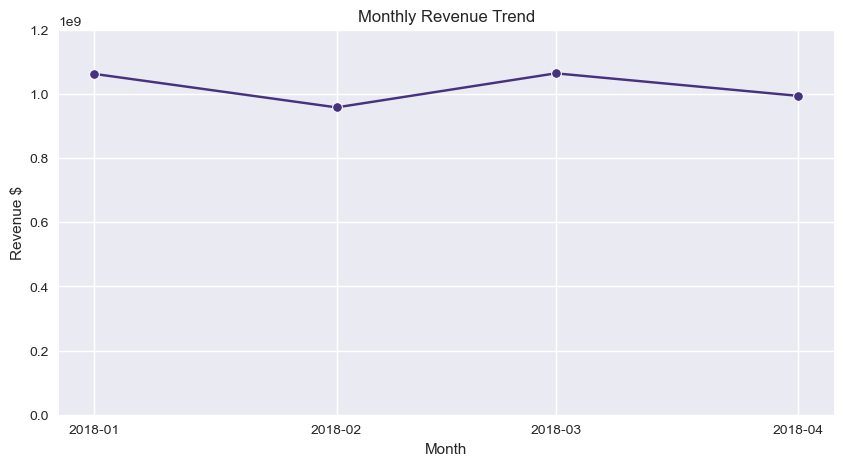

In [107]:
# Monthly revenue
df["month"] = df["salesdate"].dt.to_period("M")
monthly_revenue = df.groupby("month")["revenue"].sum().sort_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_revenue.index.to_timestamp(), y=monthly_revenue.values, marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(ticks=monthly_revenue.index.to_timestamp())
plt.ylabel("Revenue $")
plt.ylim(0, 1.2e9)
plt.show()

### Top Products & Categories

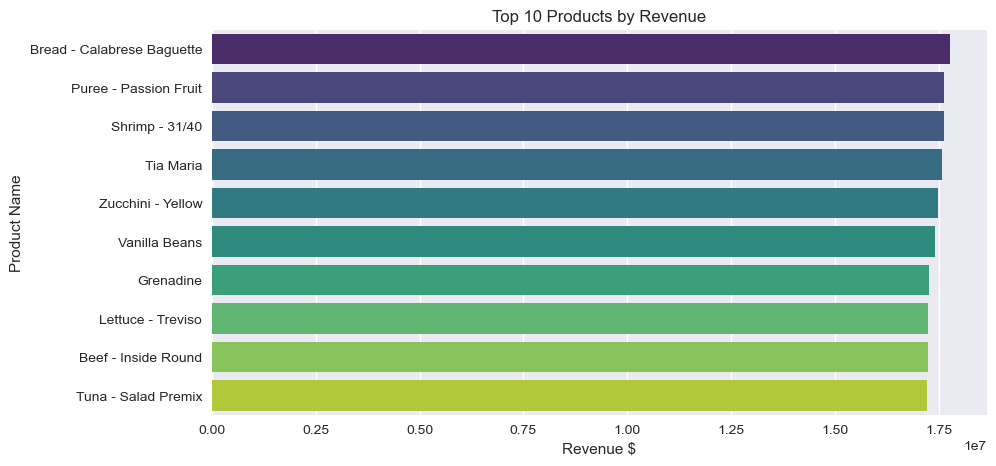

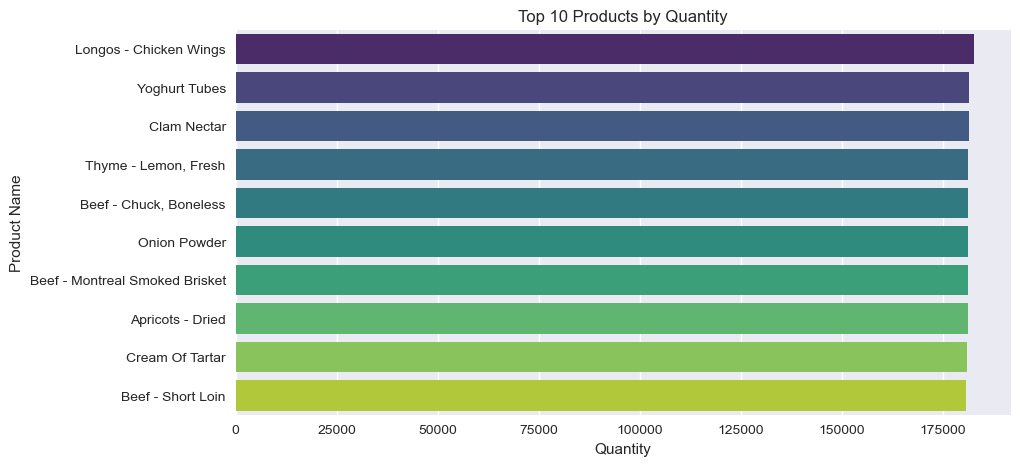

In [109]:
# Top 10 products by revenue
top_products_rev = df.groupby("productname")["revenue"].sum().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_products_rev.index, x=top_products_rev.values, palette="viridis")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue $")
plt.ylabel("Product Name")
plt.show()

# Top 10 products by quantity
top_products_qty = df.groupby("productname")["quantity"].sum().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_products_qty.index, x=top_products_qty.values, palette="viridis")
plt.title("Top 10 Products by Quantity")
plt.xlabel("Quantity")
plt.ylabel("Product Name")
plt.show()

### Customer Behavior

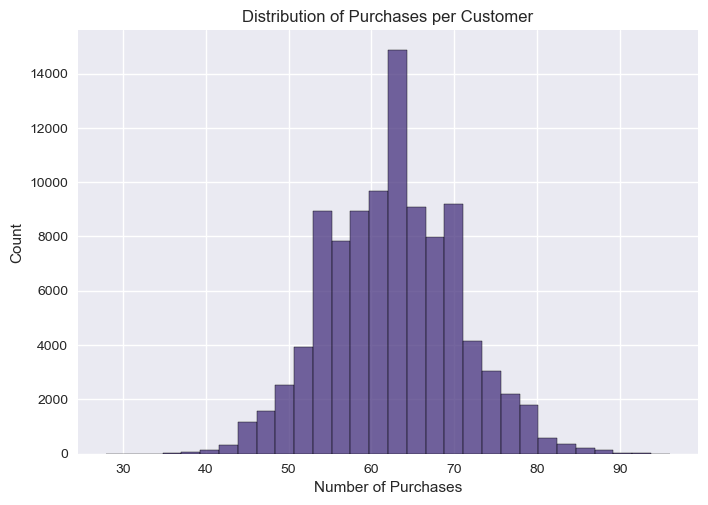

In [111]:
# Purchases per customer
purchases = df.groupby("customerid")["salesid"].count()
sns.histplot(purchases, bins=30, kde=False)
plt.title("Distribution of Purchases per Customer")
plt.xlabel("Number of Purchases")
plt.show()

#### Distribution of Purchases per Customer

The histogram shows how many purchases customers made during the analyzed period:

- Most customers fall between 55 and 70 purchases, with the peak around 60–65 purchases.

- The distribution is fairly symmetric, suggesting that purchase frequency is relatively consistent across customers.

- A small number of customers fall into the lower tail (<40 purchases) or higher tail (>80 purchases), which may represent occasional buyers and super loyal buyers, respectively.

This distribution is useful for segmentation, as it highlights that the majority of customers engage at a stable rate, while outliers on both ends could be targeted with differentiated marketing or retention strategies.

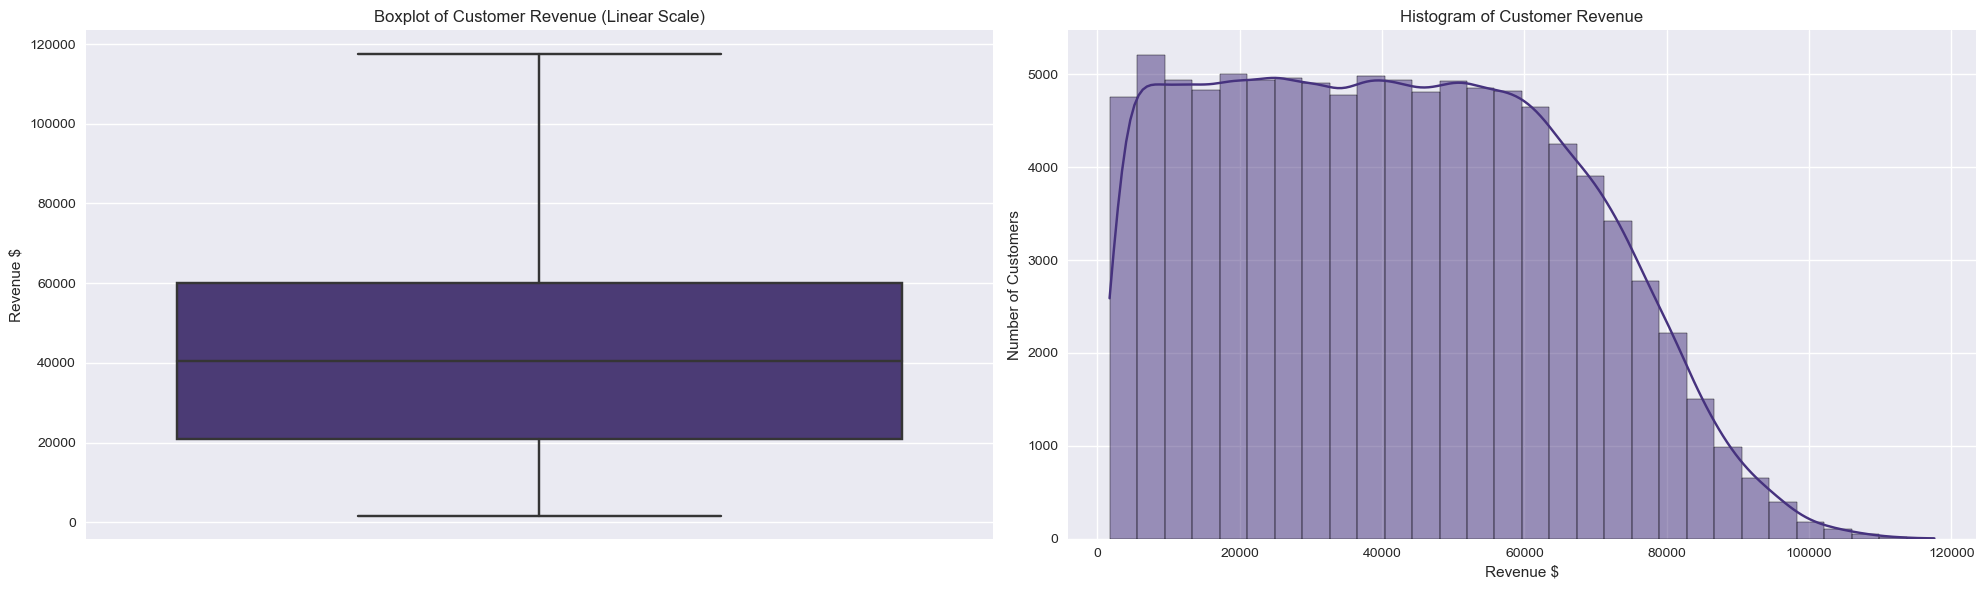

In [113]:
# Aggregate total revenue per customer
customer_revenue = df.groupby("customerid")["revenue"].sum().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20,6))

# --- Boxplot (linear scale) ---
sns.boxplot(y=customer_revenue["revenue"], ax=axes[0])
axes[0].set_title("Boxplot of Customer Revenue (Linear Scale)")
axes[0].set_ylabel("Revenue $")

# --- Histogram ---
sns.histplot(customer_revenue["revenue"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Histogram of Customer Revenue")
axes[1].set_xlabel("Revenue $")
axes[1].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()

#### Customer Revenue Distribution Analysis

The visualizations above highlight the highly skewed distribution of customer revenue:

- Boxplot (linear scale) shows that most customers generate relatively low revenue, while a small number of outliers contribute disproportionately high values. These outliers represent high-value or VIP customers.

- Histogram reinforces this observation: the majority of customers fall into the lower revenue brackets, while only a few generate very high revenue.

This analysis confirms the Pareto principle (80/20 rule) in the customer base: a small percentage of customers account for the majority of total revenue. These findings are essential for designing targeted retention strategies and customer segmentation.

   customerid  monetary  frequency  recency
0           1   3218.39         61        2
1           2   3228.26         59        7
2           3   2982.74         61        2
3           4   2943.81         63        1
4           5   2546.58         52        1


C:\Users\rodol\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


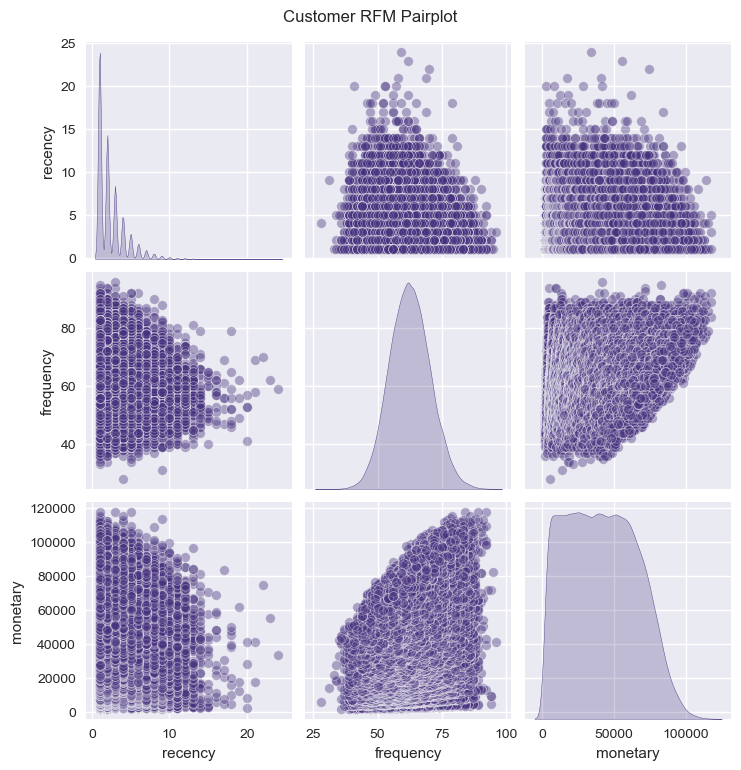

In [115]:
# Reference date: usually the max salesdate + 1 day
reference_date = df["salesdate"].max() + pd.Timedelta(days=1)

# Build RFM-style dataset
customer_rfm = df.groupby("customerid").agg(
    monetary=("revenue", "sum"),             # Total revenue
    frequency=("salesid", "count"),          # Number of purchases
    last_purchase=("salesdate", "max")       # Most recent purchase
).reset_index()

# Calculate recency in days (reference_date - last purchase date)
customer_rfm["recency"] = (reference_date - customer_rfm["last_purchase"]).dt.days

# Drop last_purchase column if not needed anymore
customer_rfm = customer_rfm.drop(columns="last_purchase")

# Preview
print(customer_rfm.head())

# Pairplot for RFM metrics
sns.pairplot(
    customer_rfm[["recency", "frequency", "monetary"]],
    diag_kind="kde",
    plot_kws={"alpha":0.4}
)

plt.suptitle("Customer RFM Pairplot", y=1.02)
plt.show()

#### Analysis of the Customer RFM Pairplot

The pairplot above shows the relationship between Recency, Frequency, and Monetary (RFM) metrics for all customers:

- Recency: The majority of customers have made very recent purchases (close to 0 days), indicating a highly active customer base. The long right tail shows a smaller set of customers who have not purchased for longer periods.

- Frequency: Most customers cluster around medium-to-high purchase frequency, but there is significant spread, suggesting the existence of both occasional and very frequent buyers.

- Monetary: Revenue contribution is heavily skewed — while many customers generate relatively low revenue, a smaller group contributes disproportionately higher revenue.

When looking at the scatter plots:

- Customers with low recency (recent buyers) tend to also have higher frequency and monetary values, which is expected in loyal customer segments.

- There is a visible long-tail effect: a small portion of customers contribute to very high revenue, while the majority contribute modest amounts.

- The combination of high frequency and high monetary reinforces the Pareto principle (80/20 rule), where a small percentage of customers drive the bulk of revenue.

This analysis highlights that customer segmentation is essential. Applying clustering methods (e.g., K-Means on RFM metrics) could help identify groups such as:

*Champions: recent, frequent, and high-spending customers.*

*Loyal: frequent buyers with moderate spending.*

*At Risk: customers with high recency (long time since last purchase).*

*Low Value: infrequent and low-spending customers.*

### Pareto Analysis

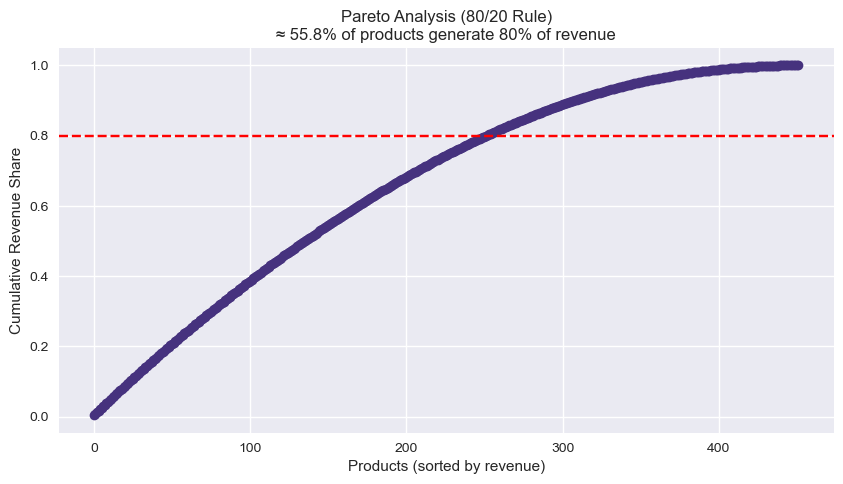

In [118]:
# Pareto analysis: % of products that generate 80% of revenue
product_revenue = df.groupby("productid")["revenue"].sum().sort_values(ascending=False)

# Cumulative share of revenue
cumulative_share = product_revenue.cumsum() / product_revenue.sum()

# Find % of products that make up 80% of revenue
pareto_cutoff = (cumulative_share <= 0.8).sum()
pareto_percentage = pareto_cutoff / len(product_revenue) * 100

# Plot
plt.figure(figsize=(10,5))
plt.plot(cumulative_share.values, marker="o")
plt.axhline(0.8, color="red", linestyle="--")

plt.title(f"Pareto Analysis (80/20 Rule)\n≈ {pareto_percentage:.1f}% of products generate 80% of revenue")
plt.xlabel("Products (sorted by revenue)")
plt.ylabel("Cumulative Revenue Share")
plt.show()

## Conclusion
The exploratory analysis provided insights into sales trends, product concentration, and customer behavior.  
Key findings include:
- Revenue is highly concentrated in a small percentage of products and customers (Pareto principle).  
- Customer activity shows strong recency and frequency patterns, with many active buyers.  
- The RFM pairplot reveals clear differences between customer groups, paving the way for segmentation.  

Next steps: apply clustering techniques (e.g., K-Means) on the RFM dataset in a dedicated notebook to identify actionable customer segments.
